# 2 Connectivity graph

## 2.1 (Mandatory) Creating the connectivity graph

In this part, we will estimate the **functional brain connectivity** obtaining the so called **connectivity graph** associated to our experiments taking into account the 64 channels and one of the following MVAR estimators:

1. Partial Directed Coherence (PDC)
1. Direct Transfer Function (DTF).

After applying this methods, we will select the matrix related to our relevant frequency value of 11 Hz so that applying a threshold we have a resulting binary matrix with a given density. Part 2.1 forces the density to 20% but we can generalize to any given density. Finally, we will plot a graphical representation of the resulting binary matrix.

### 2.1.a Creating the input matrix

In [1]:
import pyedflib
import numpy as np

def signal_matrix_from_eeg(filename):
    """
    A method to obtain the (k, N) data point matrix of signals using the pyedflib package.
    Args:
        *filename*: str
            The filename to open.
    Returns:
        *sigbufs*: np.array
            A (k, N) matrix representing k channels and N samples.
        *frequency*: int
            The sample frequency of the given data.
        *signal_labels*: [str]
            The channel labels of the given data.
    References:
    .. [1] The PyEDFlib package. To read EDF+/BDF+ files.
           http://pyedflib.readthedocs.io/en/latest/#
    """
    f = pyedflib.EdfReader(filename)
    
    k, N = f.signals_in_file, f.getNSamples()[0]
    
    sigbufs = np.zeros((k, N, 1))
    for i in np.arange(k):
        sigbufs[i, :, 0] = f.readSignal(i)
        
    return sigbufs, f.getSampleFrequency(0), f.getSignalLabels()

In [95]:
signal_38, frequency_38, names_38 = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R02.edf')
names_38 = list(map(lambda x: x.replace('.',''),  names_38))
dict_names = {idx: name for idx, name in enumerate(names_38)}
dict_number = {name: idx for idx, name in enumerate(names_38)}

### 2.1.b Obtaining the mvar model with DTF

#### 2.1.b.I Obtaining best order p

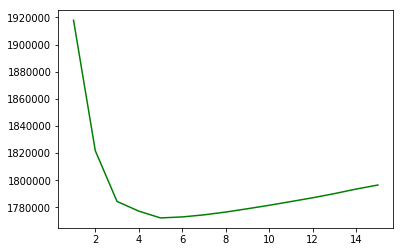

5


In [3]:
import connectivipy as cp
import matplotlib.pyplot as plt

# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# find best model order using Vieira-Morf algorithm
best, crit = mv.order_akaike(signal_38, 15, 'vm')
plt.plot(1+np.arange(len(crit)), crit, 'g')
plt.show()
print(best)

#### 2.1.b.II Fitting the mvar model 

In [4]:
# Transforming matrix to connectivipy 
data_38 = cp.Data(data=signal_38, fs=frequency_38, chan_names=names_38)

# Fitting the mvar model using Yule-Walker algorithm
data_38.fit_mvar(best, 'yw')

In [5]:
dtf = cp.conn.DTF()
av, vf = data_38.mvar_coefficients
dtfval = dtf.calculate(av, vf, frequency_38)

In [6]:
significance_dft = dtf.significance(method='yw', data=av, Nrep=10, alpha=0.05)

. . . . . . . . . . |


In [7]:
pdc = cp.conn.PDC()
av, vf = data_38.mvar_coefficients
pdcval = pdc.calculate(av, vf, frequency_38)

In [12]:
significance_dft = pdc.significance(method='yw', data=, Nrep=10, alpha=0.05)

SyntaxError: invalid syntax (<ipython-input-12-a1023c8a90ca>, line 1)

### 2.1.c Finding the best alpha

We now create the adjacency giving the output of DFT. As we want to create a directed graph, we assume that result matrix will not be symmetric. Also, we fill the output diagonal with zeros to avoid edges $\left(i,i\right) \forall i$.

As the desired density is 0.2 we will calculate the best value in order to find this density from $64*64-64 = 64*63 = 4032$ possible edges. 

If $\displaystyle \frac{x}{4032} = 0.2 \rightarrow x = 4032*0.2 = 806.4$ 

We need to find the alpha ($\alpha$) such that the number of edges in the network is as close to 806 as possible. To do this, we implement a similar method to binary search in which we try to find the closest possible value that reach the desired density 0.2. As a result, we start our search from the space of $\alpha$ which is the interval $\left(0, 1\right)$.

Notes:

1. We assume that the need to find the closest possible alpha ($\alpha$) such that the density is **at least** 0.2. As $\displaystyle \frac{x}{4032}$ is not an integer, our algorithm stops with the closes integer $x$ such that $x>806.4$.
1. We stop when the closest integer doesn't change in 2 iterations.
1. It's possible that a density $d_l$ that denotes a lower bound such that $d_l < 0.2$ is closer to 0.2 than the output of our algorithm. However, we finding the alpha such that $d_\alpha-0.2>0$ with $d_\alpha$ denoting the density of the binary matrix using $\alpha$ threshold.

In [8]:
interest_matrix = dtfval[11, :, :].reshape((64, 64))
np.fill_diagonal(interest_matrix, 0)

In [9]:
def find_best_alpha(interest, desired_density=0.2, tol=1e-3, N=64, n_iter=100, debug=True):
    search_space = [0.0, 1.0]
    density, i = 0, 0
    best_alpha, this_alpha, best_n = -1, 0, 4096
    target = int(N*(N-1)*desired_density)
   
    if debug:
        print("Desired number of nodes: {} for desired density {}".format(target, desired_density))
    
    while best_alpha != this_alpha:
        best_alpha = this_alpha
        for alpha in np.arange(search_space[0], search_space[1], (search_space[1] - search_space[0])/100.0):
            n = len(np.where(interest > alpha)[0])
            if abs(n-target) < abs(best_n-target) and n-target>0:
                this_alpha, best_n = alpha, n
        if debug:
            print("In search_space({:0.3f},{:0.3f}) alpha: {:0.3f} best_n: {} proportion: {:0.3f}".format(search_space[0], 
                                                                                                       search_space[1], 
                                                                                                       this_alpha, 
                                                                                                       best_n, 
                                                                                                       best_n/(N*(N-1))))
        search_space[0], search_space[1] = this_alpha-tol, this_alpha+tol

    return best_alpha

In [10]:
best_alpha = find_best_alpha(interest=interest_matrix, 
                             desired_density=0.2, 
                             tol=1e-3)

Desired number of nodes: 806 for desired density 0.2
In search_space(0.000,1.000) alpha: 0.130 best_n: 837 proportion: 0.208
In search_space(0.129,0.131) alpha: 0.131 best_n: 820 proportion: 0.203
In search_space(0.130,0.132) alpha: 0.132 best_n: 810 proportion: 0.201
In search_space(0.131,0.133) alpha: 0.132 best_n: 807 proportion: 0.200
In search_space(0.131,0.133) alpha: 0.132 best_n: 807 proportion: 0.200


In [11]:
import pandas as pd
import networkx as nx

In [12]:
def create_adjacency_matrix(interest, alpha):
    return np.array(interest > alpha, dtype=np.int)

In [13]:
binary_matrix = create_adjacency_matrix(interest_matrix, best_alpha)

### (2.1.d - 2.5) Creation and topological representation of the graph

We will unify last points of 2.1 and 2.5 in one question. Creating the topological representation of the graph is setting the position of the constructor of the directed graph (DiGraph).

#### Getting position data

In [14]:
def create_position_graph(filename):    
    location = pd.read_csv(filename, sep="\t", encoding='latin-1', index_col=0)
    position_data = {label.replace('.', ''): (x, y) for label, x, y in zip(location['label'], location['x'], location['y'])}
    
    return position_data

In [15]:
position_data = create_position_graph('location_data/channel_locations.txt')

#### Creating the graph

In [16]:
def create_edges_list(input_matrix, alpha, weighted=False):
    x, y = np.where(interest_matrix > alpha)
        
    if weighted:
        return list(zip(map(lambda idx: dict_names[idx], x), 
                        map(lambda idy: dict_names[idy], y), 
                        map(lambda x: interest_matrix[x[0]][x[1]], list(zip(x, y))))) 
    else:
        return list(zip(map(lambda idx: dict_names[idx], x), map(lambda idy: dict_names[idy], y)))

def create_directed_graph(input_matrix, alpha, position, weighted=False):
    G = nx.DiGraph()
    G.add_nodes_from(position_data.keys(), style='filled',fillcolor='red', pos=position, nodesize=10)
    
    if weighted:
        G = nx.DiGraph((x, y, {'weight':w}) for (x, y, w) in create_edges_list(input_matrix, alpha, weighted=True))
    else:
        G.add_edges_from(create_edges_list(input_matrix, alpha))
    
    return G

In [17]:
directed_graph = create_directed_graph(input_matrix=interest_matrix,
                                       alpha=best_alpha,
                                       position=position_data)

#### Topological representation

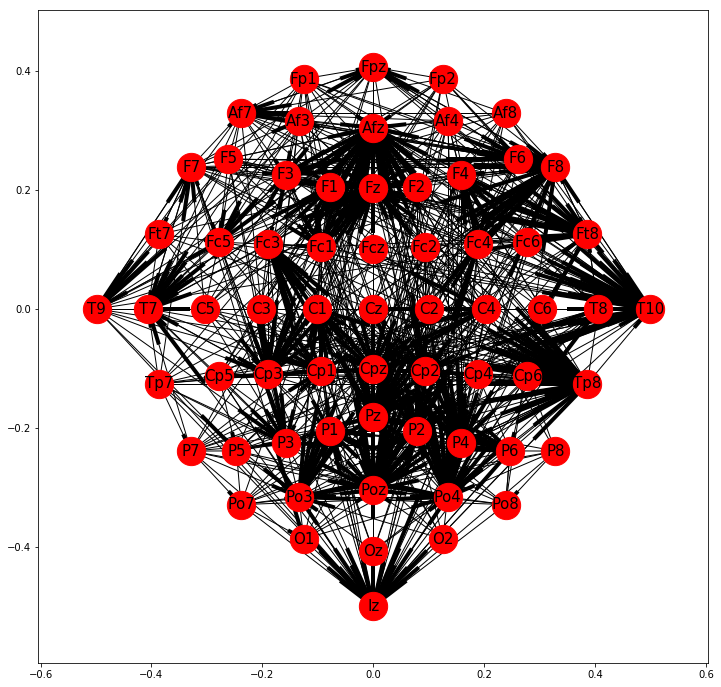

In [18]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(directed_graph, position_data, node_size=800, font_size=15)
plt.show()

### 2.1.e Drawing the adjacency matrix

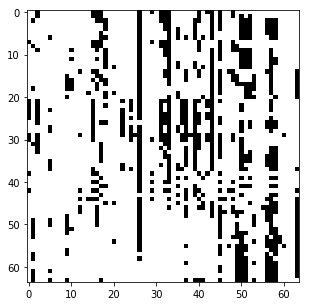

In [19]:
fig = plt.figure(figsize=(5, 5)) # in inches
plt.imshow(binary_matrix,
              cmap="Greys",
              interpolation="none")
plt.show()

# 3 Graph  theory  indices
## 3.1. (Mandatory) Compute binary global (clustering coefficient, path length) and local (degree, in/out-degree) graph indices. List the highest 10 channels for local indices.

In this part, we compute the global **clustering coefficient** and **path length** and local **in/out-degree** of the graph previously generated.

In order to save time we computed the communities we needed also for the 5.1 on the same function.


In [20]:
import louvain 
from igraph import *
import pandas as pd
import igraph as ig

In [65]:
def graph_theory_indices(g_nx):
    #computing the average_clustering coefficient
    lcc = max(nx.connected_components(g_nx.to_undirected()), key=len)
    
    average_clustering_coefficient = nx.average_clustering(g_nx.to_undirected().subgraph(list(lcc)))
    #converting into igraph
    g = ig.Graph.TupleList(g_nx.edges(), directed=True)
    #generating the clustering using louvain
    clustering = {}
    partition = louvain.find_partition(g, louvain.ModularityVertexPartition)
    for i in range(len(partition)):
        clustering[i]=partition[i]
    #computing the average_path_length
    average_path_length = g.average_path_length()
    #generating the data-frame with the nodes and its degree information
    vs = VertexSeq(g)
    vertex = []
    indegree = []
    outdegree = []
    degree = []
    for i in vs:
        vertex.append(i['name'])
        indegree.append(g.degree(i['name'], type="in"))
        outdegree.append(g.degree(i['name'], type="out"))
        degree.append(g.degree(i['name']))
    d = {'vertex': vertex, 'in-degree': indegree, 'out-degree': outdegree,'degree': degree}
    degree_info = pd.DataFrame(data=d)
    degree_info = degree_info[['vertex', 'in-degree', 'out-degree', 'degree']]
    degree_info=degree_info.sort_values(by=['degree'], ascending=False)
    return(clustering, average_clustering_coefficient, average_path_length, degree_info)
 #remember to degree_info.head(10)


Getting the information we were asked

In [66]:
(clustering,average_clustering, average_path_length,degree_info) =graph_theory_indices(directed_graph)

/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead
/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead


Global information:

We got as **clustering coefficient**:

In [67]:
average_clustering

0.6528626309490608

And as **average path length**:

In [68]:
average_path_length

2.1103278110680295

Local information:

The information of **in/out-degree** is stored in the data frame degree_info, as we were asked, we only show the TOP-10.

In [69]:
degree_info.head(10)

,vertex,in-degree,out-degree,degree
5,Afz,56,19,75
22,Poz,50,8,58
9,Fz,41,12,53
13,Tp8,43,10,53
16,Pz,41,10,51
12,T10,40,8,48
42,Iz,28,16,44
29,F8,29,15,44
23,Po4,34,8,42
19,Ft8,28,10,38


## 3.4- (class ‘C’) Study the behaviour of global graph indices in function of network density.

In order to study the behaviour for different densities we wrote the following function:

In [70]:
def behaviour_density(interest_matrix, densities=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5]):
    global_clustering, global_path_length, best_alphas = [], [], []
    
    for density in densities:
        best_alpha = find_best_alpha(interest=interest_matrix, 
                                     desired_density=density, 
                                     tol=1e-3,
                                     debug=False)
        
        best_alphas.append(best_alpha)
        
        community_graph = create_directed_graph(input_matrix=interest_matrix,
                                                alpha=best_alpha,
                                                position=position_data)
        
        _, clustering, average_path_length, _  =graph_theory_indices(community_graph)
        
        global_clustering.append(clustering)
        global_path_length.append(average_path_length)
    
    d = {'Clustering coefficient': global_clustering, 
         'Average path length':global_path_length,
         'Densities': densities,
         'Best alpha': best_alphas}
    
    behaviour_df = pd.DataFrame(data=d)
    
    return behaviour_df[['Densities', 'Best alpha', 'Clustering coefficient', 'Average path length']]

We stored all the information in the following dataframe:

In [71]:
behaviour = behaviour_density(interest_matrix=interest_matrix)

/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead
/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead


In [72]:
behaviour

,Densities,Best alpha,Clustering coefficient,Average path length
0,0.01,0.33000,0.042602,1.222222
1,0.05,0.21324,0.564534,2.473819
2,0.10,0.16904,0.547150,2.465508
3,0.20,0.13198,0.652863,2.110328
4,0.30,0.10876,0.686687,1.816712
5,0.50,0.07654,0.819633,1.497268


Studying the best alpha, we got that the bigger the density the smaller the alpha. A behaviour expected because of the definition of alpha.

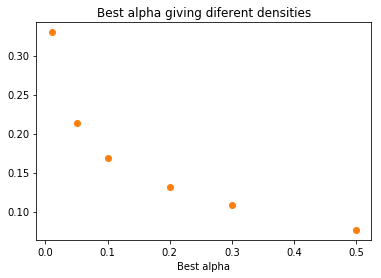

In [73]:
plt.plot(behaviour['Densities'], behaviour['Best alpha'], '-o', color='C1')
plt.xlabel('Densities')
plt.ylabel('Best alpha')
plt.title("Best alpha giving diferent densities")
plt.show()

Studying the clustering coefficient, we got that the bigger the density, the bigger the alpha. A behaviour expected because of the definition of Clusteing coefficient.

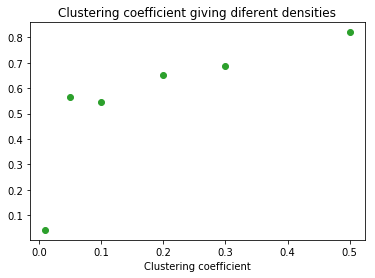

In [74]:
plt.plot(behaviour['Densities'], behaviour['Clustering coefficient'], '-o', color='C2')
plt.xlabel('Densities')
plt.ylabel('Clustering coefficient')
plt.title("Clustering coefficient giving diferent densities")
plt.show()


Studying the average path length, we can see that: when the density is little the graph is not connected so when the average path length is computed it is done on the connected part and since the number of nodes into it is little the average path length is also little. As soon as the density is enough to make the graph connected, the average path length grows rapidly and from this point, as the density increases the average path length decreases and it will end up being 1 when the density is equal to 1 so the graph is complete.

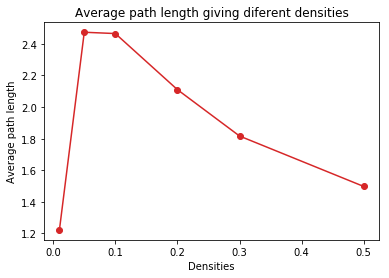

In [79]:
plt.plot(behaviour['Densities'], behaviour['Average path length'], '-o', color='C3')
plt.xlabel('Densities')
plt.ylabel('Average path length')
plt.title("Average path length giving diferent densities")
plt.show()

# 5 Community detection
## 5.1. (Mandatory) Determine number and composition (i.e. list of nodes) of the communities obtained applying one of the algorithms introduced during the course.

As we explained on the 3.1, we computed the communities on that exercise. We used Louvain algorithm. We kept this information in the dictionary called clustering. In order to make it more readable, we created the following function to show the information obtained in a data frame:

In [117]:
def community(clustering):
    number = []
    total = []
    nodes = []

    for i in clustering.keys():
        number.append(i)
        nodes.append(clustering[i])
        total.append(len(clustering[i]))
    
    d = {'community': number, 'total': total, 'nodes': nodes}
    
    community_detection = pd.DataFrame(data=d)
    community_detection = community_detection[['community', 'total', 'nodes']]
    community_detection['nodes'] = community_detection['nodes'].apply(lambda x: list(map(lambda y: dict_names[y], x)))
    return(community_detection)

In the following data frame you can see the communities information

In [118]:
community_info = community(clustering)
community_info

,community,total,nodes
0,0,28,"[C6, Cp1, Cpz, Cp2, Cp6, Fp1, Fpz, Fp2, Af7, A..."
1,1,18,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."
2,2,14,"[C4, Cp4, Afz, Af4, Af8, F7, Tp8, P7, P5, P3, ..."
3,3,4,"[F8, T7, Poz, Po4]"
